<a href="https://colab.research.google.com/github/merttezcan/Bitcoin-Price-Prediction-using-LSTM/blob/main/dl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout

In [13]:
#getting the data

data = pd.read_csv('BTC-USD-5-years.csv', date_parser = True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,2022-09-29,19427.779297,19589.265625,18924.353516,19573.050781,19573.050781,41037843771
1823,2022-09-30,19573.431641,20109.849609,19265.662109,19431.789063,19431.789063,43975248085
1824,2022-10-01,19431.105469,19471.154297,19231.082031,19312.095703,19312.095703,18719537670
1825,2022-10-02,19311.849609,19370.308594,18970.621094,19044.107422,19044.107422,20765955327
1826,2022-10-03,19039.136719,19421.876953,19039.136719,19413.570313,19413.570313,27688695808


In [14]:
#splitting the data into training and test sets

raw_training_data = data[data['Date']< '2020-01-01'].copy()
raw_test_data = data[data['Date']> '2020-01-01'].copy()

training_data = raw_training_data.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,4408.459961,4432.470215,4258.890137,4317.479980,1288019968
1,4319.370117,4352.310059,4210.419922,4229.359863,1116770048
2,4229.879883,4362.640137,4164.049805,4328.410156,1161769984
3,4324.459961,4413.270020,4320.529785,4370.810059,1069939968
4,4369.350098,4443.879883,4321.049805,4426.890137,906928000


In [15]:
#applying minmax scaler, it preserves the shape, so we can unscale it at the end and check the prices

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.072181  , 0.06881874, 0.06764243, 0.06646223, 0.00862222],
       [0.06669502, 0.06405117, 0.06457135, 0.061043  , 0.00474769],
       [0.06118437, 0.06466556, 0.06163333, 0.06713441, 0.00576581],
       ...,
       [0.25132339, 0.25209145, 0.2590518 , 0.25742477, 0.4873057 ],
       [0.25764288, 0.24857501, 0.25882642, 0.24945105, 0.49700899],
       [0.24989426, 0.24146565, 0.25207665, 0.24333838, 0.45840647]])

In [16]:
#creating X_train and Y_train

X_train = [] 
Y_train = []

In [17]:
#checking the shape of the training data

training_data.shape[0]

820

In [18]:
#generating sequences for LSTM

for i in range(100, training_data.shape[0]):
  X_train.append(training_data[i-100:i])
  Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(720, 100, 5)

In [19]:
#creating the LSTM model with one dropout and one dense layer

model = Sequential()
model.add(LSTM(units = 100, activation = 'relu', input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               42400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [20]:
#training

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 50, validation_split = 0.1)

Epoch 1/20
13/13 [==============================] - 4s 177ms/step - loss: 0.0302 - val_loss: 0.0108
Epoch 2/20
13/13 [==============================] - 2s 161ms/step - loss: 0.0090 - val_loss: 0.0017
Epoch 3/20
13/13 [==============================] - 2s 164ms/step - loss: 0.0055 - val_loss: 8.1497e-04
Epoch 4/20
13/13 [==============================] - 2s 161ms/step - loss: 0.0046 - val_loss: 8.7057e-04
Epoch 5/20
13/13 [==============================] - 2s 161ms/step - loss: 0.0039 - val_loss: 5.5212e-04
Epoch 6/20
13/13 [==============================] - 2s 161ms/step - loss: 0.0036 - val_loss: 4.4473e-04
Epoch 7/20
13/13 [==============================] - 2s 164ms/step - loss: 0.0042 - val_loss: 6.0661e-04
Epoch 8/20
13/13 [==============================] - 2s 155ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 9/20
13/13 [==============================] - 2s 160ms/step - loss: 0.0037 - val_loss: 7.4523e-04
Epoch 10/20
13/13 [==============================] - 2s 157ms/step - loss: 0

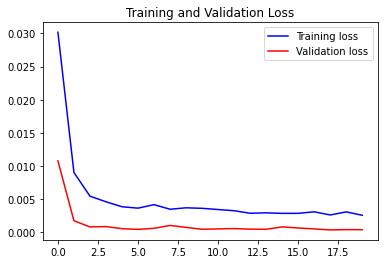

In [21]:
#analysing the losses

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [22]:
#creating a test dataset using the data of last 100 days

seq_60_days = raw_training_data.tail(100)
df= seq_60_days.append(raw_test_data, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df

,Open,High,Low,Close,Volume
0,10067.962891,10074.238281,9727.143555,9729.324219,15144925408
1,9729.321289,9804.317383,8370.801758,8620.566406,25002886689
2,8603.428711,8744.828125,8325.396484,8486.993164,21744728353
3,8487.669922,8515.685547,7895.629395,8118.967773,19258205289
4,8113.101074,8271.520508,7965.922852,8251.845703,16408941156
...,...,...,...,...,...
1101,19427.779297,19589.265625,18924.353516,19573.050781,41037843771
1102,19573.431641,20109.849609,19265.662109,19431.789063,43975248085
1103,19431.105469,19471.154297,19231.082031,19312.095703,18719537670
1104,19311.849609,19370.308594,18970.621094,19044.107422,20765955327


In [23]:
#scaling the test dataset

inputs = scaler.transform(df)
inputs

array([[0.42068273, 0.40436619, 0.41411167, 0.3992809 , 0.32213535],
       [0.39982981, 0.38831249, 0.32817368, 0.33109429, 0.54517217],
       [0.33049943, 0.32529875, 0.3252968 , 0.32287978, 0.47145619],
       ...,
       [0.99724775, 0.96325327, 1.01628244, 0.9886041 , 0.40301111],
       [0.98990419, 0.95725541, 0.9997796 , 0.9721233 , 0.44931141],
       [0.97311103, 0.96032247, 1.00412076, 0.9948446 , 0.60593873]])

In [24]:
#generating sequences for test dataset

X_test = []
Y_test = []

for i in range (100, inputs.shape[0]):
  X_test.append(inputs[i-100:i])
  Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape
Y_pred = model.predict(X_test)
#Y_pred, Y_test

In [25]:
scaler.scale_

array([6.15781515e-05, 5.94755845e-05, 6.33601290e-05, 6.14981994e-05,
       2.26250460e-11])

In [26]:
scale = 1/5.18164146e-05

In [27]:
#unscaling to see the prices in correct way

Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [28]:
#Y_pred

In [29]:
#Y_test

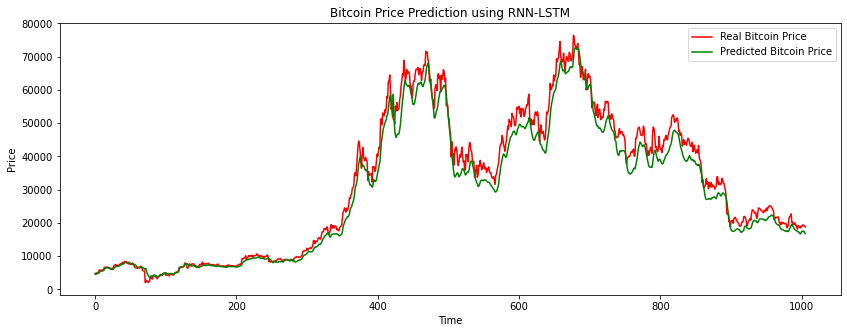

In [30]:
#final plot

plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()